<a href="https://colab.research.google.com/github/datascience-1100/Finding-insights-about-Penguins/blob/main/K_means_model%20on%20Penguins%20Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Build a K-means model

## **Introduction**

K-means clustering is very effective when segmenting data and attempting to find patterns.    

If, we are consultants for a scientific organization that works to support and sustain penguin colonies. We are tasked with helping other staff members learn more about penguins in order to achieve this mission.

We will use a K-means clustering model to group this data and identify patterns that provide important insights about penguins.


## **Step 1: Imports**

In [3]:
# Import standard operational packages.
import numpy as np
import pandas as pd

# Important tools for modeling and evaluation.
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Import visualization packages.
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#Load the dataframe
penguins = pd.read_csv("penguins.csv")

In [5]:
# Review the first 10 rows.

penguins.head(10)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male
6,Adelie,Torgersen,38.9,17.8,181.0,3625.0,female
7,Adelie,Torgersen,39.2,19.6,195.0,4675.0,male
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN


## **Step 2: Data exploration**

After loading the dataset, the next step is to prepare the data to be suitable for clustering. This includes:

*   Exploring data
*   Checking for missing values
*   Encoding data
*   Dropping a column
*   Scaling the features using `StandardScaler`

### Explore data

To cluster penguins of multiple different species, determine how many different types of penguin species are in the dataset.

In [6]:
# Find out how many penguin types there are.
penguins['species'].unique()

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

In [7]:
# Find the count of each species type.
penguins['species'].value_counts(dropna = False)

Adelie       152
Gentoo       124
Chinstrap     68
Name: species, dtype: int64

**Question:** How many types of species are present in the dataset?

There are three types of species. Note the Chinstrap species is less common than the other species. This has a chance to affect K-means clustering as K-means performs best with similar sized groupings.

**Question:** Why is it helpful to determine the perfect number of clusters using K-means when you already know how many penguin species the dataset contains?

For purposes of clustering, pretend you don't know that there are three different types of species. Then, you can explore whether the algorithm can discover the different species. You might even find other relationships in the data.

### Check for missing values

An assumption of K-means is that there are no missing values. Check for missing values in the rows of the data.

In [8]:
# Check for missing values.
penguins.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

Drop the rows with missing values and save the resulting pandas DataFrame in a variable named `penguins_subset`.

In [9]:
# Drop rows with missing values.
# Save DataFrame in variable `penguins_subset`.

penguins_subset = penguins.dropna(axis=0).reset_index(drop = True)

Next, check to make sure that `penguins_subset` does not contain any missing values.

In [10]:
# Check for missing values.
penguins_subset.isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

Now, review the first 10 rows of the subset.

In [11]:
# View first 10 rows.
penguins_subset.head(10)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male
5,Adelie,Torgersen,38.9,17.8,181.0,3625.0,female
6,Adelie,Torgersen,39.2,19.6,195.0,4675.0,male
7,Adelie,Torgersen,41.1,17.6,182.0,3200.0,female
8,Adelie,Torgersen,38.6,21.2,191.0,3800.0,male
9,Adelie,Torgersen,34.6,21.1,198.0,4400.0,male


### Encode data

Some versions of the penguins dataset have values encoded in the sex column as 'Male' and 'Female' instead of 'MALE' and 'FEMALE'. The code below will make sure all values are ALL CAPS.


In [12]:
penguins_subset['sex'] = penguins_subset['sex'].str.upper()
penguins_subset['sex']

0        MALE
1      FEMALE
2      FEMALE
3      FEMALE
4        MALE
        ...  
328    FEMALE
329    FEMALE
330      MALE
331    FEMALE
332      MALE
Name: sex, Length: 333, dtype: object

K-means needs numeric columns for clustering. Convert the categorical column `'sex'` into numeric. There is no need to convert the `'species'` column because it isn't being used as a feature in the clustering algorithm.

In [13]:
# Convert `sex` column from categorical to numeric.
penguins_subset = pd.get_dummies(penguins_subset, drop_first = True, columns=['sex'])

### Drop a column

Drop the categorical column `island` from the dataset. While it has value, this notebook is trying to confirm if penguins of the same species exhibit different physical characteristics based on sex. This doesn't include location.

Note that the `'species'` column is not numeric. Don't drop the `'species'` column for now. It could potentially be used to help understand the clusters later.

In [14]:
# Drop the island column.
penguins_subset = penguins_subset.drop(['island'], axis=1)

### Scale the features

Because K-means uses distance between observations as its measure of similarity, it's important to scale the data before modeling. Use a third-party tool, such as scikit-learn's `StandardScaler` function. `StandardScaler` scales each point xᵢ by subtracting the mean observed value for that feature and dividing by the standard deviation:

x-scaled = (xᵢ – mean(X)) / σ

This ensures that all variables have a mean of 0 and variance/standard deviation of 1.

**Note:** Because the species column isn't a feature, it doesn't need to be scaled.

First, copy all the features except the `'species'` column to a DataFrame `X`.

In [15]:
# Exclude `species` variable from X
X = penguins_subset.drop(['species'], axis=1)

Scale the features in `X` using `StandardScaler`, and assign the scaled data to a new variable `X_scaled`.

In [16]:
#Scale the features.
#Assign the scaled data to variable `X_scaled`.


X_scaled = StandardScaler().fit_transform(X)

## **Step 3: Data modeling**

Now, fit K-means and evaluate inertia for different values of k. Because you may not know how many clusters exist in the data, start by fitting K-means and examining the inertia values for different values of k. To do this, write a function called `kmeans_inertia` that takes in `num_clusters` and `x_vals` (`X_scaled`) and returns a list of each k-value's inertia.

When using K-means inside the function, set the `random_state` to `42`. This way, others can reproduce your results.

In [17]:
# Fit K-means and evaluate inertia for different values of k.


num_clusters = [i for i in range(2, 9)]

def kmeans_inertia(num_clusters, x_vals):
    """
    Accepts as arguments list of ints and data array.
    Fits a KMeans model where k = each value in the list of ints.
    Returns each k-value's inertia appended to a list.
    """
    inertia = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=42)
        kms.fit(x_vals)
        inertia.append(kms.inertia_)

    return inertia

Use the `kmeans_inertia` function to return a list of inertia for k=2 to 10.

In [18]:
# Return a list of inertia for k=2 to 10.


inertia = kmeans_inertia(num_clusters, X_scaled)
inertia

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

[885.622414365225,
 578.8284278107235,
 386.14534424773285,
 284.5464837898288,
 217.92858573807686,
 201.39287843423276,
 185.4613104323231]

Next, create a line plot that shows the relationship between `num_clusters` and `inertia`.
Use either seaborn or matplotlib to visualize this relationship.

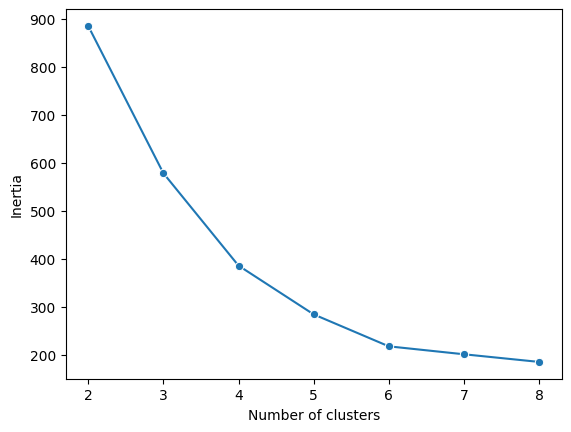

In [19]:
# Create a line plot.


plot = sns.lineplot(x=num_clusters, y=inertia, marker = 'o')
plot.set_xlabel("Number of clusters");
plot.set_ylabel("Inertia");

**Question:** Where is the elbow in the plot?

The plot seems to depict an elbow at six clusters, but there isn't a clear method for confirming that a six-cluster model is optimal. Therefore, the silhouette scores should be checked.

## **Step 4: Results and evaluation**

Now, evaluate the silhouette score using the `silhouette_score()` function. Silhouette scores are used to study the distance between clusters.

Then, compare the silhouette score of each value of k, from 2 through 10. To do this, write a function called `kmeans_sil` that takes in `num_clusters` and `x_vals` (`X_scaled`) and returns a list of each k-value's silhouette score.

In [20]:
# Evaluate silhouette score.
# Write a function to return a list of each k-value's score.


def kmeans_sil(num_clusters, x_vals):
    """
    Accepts as arguments list of ints and data array.
    Fits a KMeans model where k = each value in the list of ints.
    Calculates a silhouette score for each k value.
    Returns each k-value's silhouette score appended to a list.
    """
    sil_score = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=42)
        kms.fit(x_vals)
        sil_score.append(silhouette_score(x_vals, kms.labels_))

    return sil_score


sil_score = kmeans_sil(num_clusters, X_scaled)
sil_score

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

[0.44398088353055243,
 0.45101024097188364,
 0.5080140996630784,
 0.519998574860868,
 0.5263224884981607,
 0.47774022332151733,
 0.4221920732643224]

Next, create a line plot that shows the relationship between `num_clusters` and `sil_score`.
Use either seaborn or matplotlib to visualize this relationship.

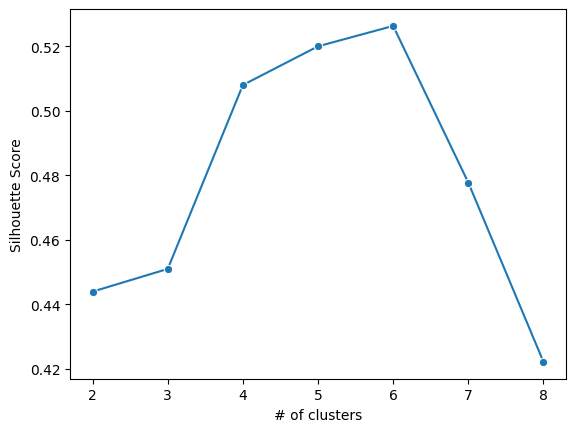

In [21]:
# Create a line plot.


plot = sns.lineplot(x=num_clusters, y=sil_score, marker = 'o')
plot.set_xlabel("# of clusters");
plot.set_ylabel("Silhouette Score");

**Question:** What does the graph show?

Silhouette scores near 1 indicate that samples are far away from neighboring clusters. Scores close to 0 indicate that samples are on or very close to the decision boundary between two neighboring clusters.

The plot indicates that the silhouette score is closest to 1 when the data is partitioned into six clusters, although five clusters also yield a relatively good silhouette score.

### Optimal k-value

To decide on an optimal k-value, fit a six-cluster model to the dataset.

In [22]:
# Fit a 6-cluster model.


kmeans6 = KMeans(n_clusters=6, random_state=42)
kmeans6.fit(X_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=6, random_state=42)

Print out the unique labels of the fit model.

In [23]:
# Print unique labels.


print('Unique labels:', np.unique(kmeans6.labels_))

Unique labels: [0 1 2 3 4 5]


Now, create a new column `cluster` that indicates cluster assignment in the DataFrame `penguins_subset`. It's important to understand the meaning of each cluster's labels, then decide whether the clustering makes sense.

**Note:** This task is done using `penguins_subset` because it is often easier to interpret unscaled data.

In [24]:
# Create a new column `cluster`.


penguins_subset['cluster'] = kmeans6.labels_
penguins_subset.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_MALE,cluster
0,Adelie,39.1,18.7,181.0,3750.0,1,2
1,Adelie,39.5,17.4,186.0,3800.0,0,1
2,Adelie,40.3,18.0,195.0,3250.0,0,1
3,Adelie,36.7,19.3,193.0,3450.0,0,1
4,Adelie,39.3,20.6,190.0,3650.0,1,2


Use `groupby` to verify if any `'cluster'` can be differentiated by `'species'`.

In [25]:
# Verify if any `cluster` can be differentiated by `species`.


penguins_subset.groupby(by=['cluster', 'species']).size()

cluster  species  
0        Gentoo       58
1        Adelie       73
         Chinstrap     5
2        Adelie       71
3        Adelie        2
         Chinstrap    34
4        Gentoo       61
5        Chinstrap    29
dtype: int64

Next, interpret the groupby outputs. Although the results of the groupby show that each `'cluster'` can be differentiated by `'species'`, it is useful to visualize these results. The graph shows that each `'cluster'` can be differentiated by `'species'`.

**Note:** The code for the graph below is outside the scope of this lab.

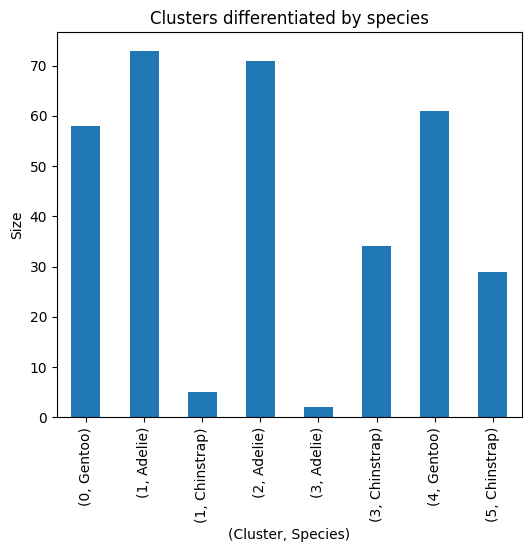

In [26]:
penguins_subset.groupby(by=['cluster', 'species']).size().plot.bar(title='Clusters differentiated by species',
                                                                   figsize=(6, 5),
                                                                   ylabel='Size',
                                                                   xlabel='(Cluster, Species)');

Use `groupby` to verify if each `'cluster'` can be differentiated by `'species'` AND `'sex_MALE'`.

In [27]:
# Verify if each `cluster` can be differentiated by `species` AND `sex_MALE`.

penguins_subset.groupby(by=['cluster','species', 'sex_MALE']).size().sort_values(ascending = False)

cluster  species    sex_MALE
1        Adelie     0           73
2        Adelie     1           71
4        Gentoo     1           61
0        Gentoo     0           58
3        Chinstrap  1           34
5        Chinstrap  0           29
1        Chinstrap  0            5
3        Adelie     1            2
dtype: int64

**Question:** Are the clusters differentiated by `'species'` and `'sex_MALE'`?

Even though clusters 1 and 3 weren't all one species or sex, the `groupby` indicates that the algorithm produced clusters mostly differentiated by species and sex.

Finally, interpret the groupby outputs and visualize these results. The graph shows that each `'cluster'` can be differentiated by `'species'` and `'sex_MALE'`. Furthermore, each cluster is mostly comprised of one sex and one species.



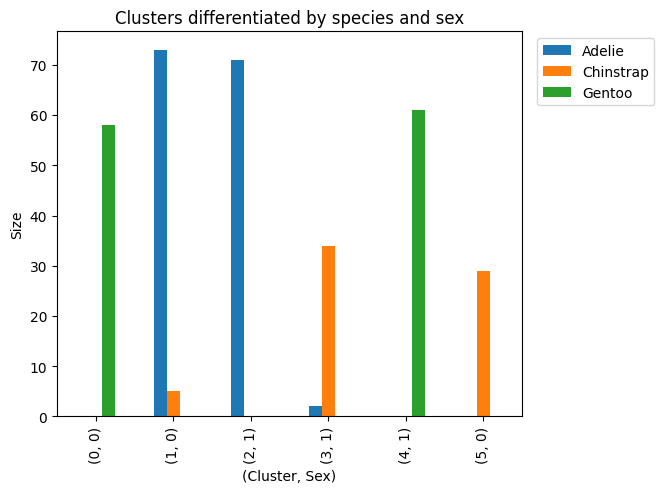

In [28]:
penguins_subset.groupby(by=['cluster','species','sex_MALE']).size().unstack(level = 'species', fill_value=0).plot.bar(title='Clusters differentiated by species and sex',
                                                                                                                      figsize=(6, 5),
                                                                                                                      ylabel='Size',
                                                                                                                      xlabel='(Cluster, Sex)')
plt.legend(bbox_to_anchor=(1.3, 1.0))

## **Considerations**

**Key takeaways **
-   Many machine learning workflows are about cleaning, encoding, and scaling data.
-   Inertia and silhouette score can be used to find the optimal value of clusters.
-   Clusters can find natural groupings in data.
-   The clusters in this lab are mostly differentiated by species and sex as shown by the groupby results and corresponding graphs.
-   The elbow plot and especially the silhouette scores suggests that 6 clusters are optimal for this data.
-   Having 6 clusters makes sense because the study suggests that there is sexual dimorphism (differences between the sexes) for each of the three species (2 sexes * 3 different species = 6 clusters).

**What summary would you provide to stakeholders?**
*  The K-means clustering enabled this data to be effectively grouped. It helped identify patterns that can educate team members about penguins.
*  The success of the cluster results suggests that the organization can apply clustering to other projects and continue augmenting employee education.



